In [1]:
%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from config import enable_gpu_momory_dynamic_growth
from config import disable_tensorflow_warning
from config import enable_cuda_visible_devices
from dataset import load
from models import SINet
from models import FCN
disable_tensorflow_warning()
enable_gpu_momory_dynamic_growth()
enable_cuda_visible_devices("0")

In [2]:
print(tf.__version__)
!nvidia-smi

2.6.0
Sun Jul  3 15:13:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 30%   35C    P5   105W / 350W |   4358MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 

In [3]:
#Load UCI-HAR Dataset
x_train,y_train,x_test,y_test=load(mode='sequence')
x_train_f,y_train_f,x_test_f,y_test_f=load(mode='feature')

In [4]:
#Convert to one-hot encoding
y_train=tf.keras.utils.to_categorical(y_train,6)
y_test=tf.keras.utils.to_categorical(y_test,6)

y_train_f=tf.keras.utils.to_categorical(y_train_f-1,6)
y_test_f=tf.keras.utils.to_categorical(y_test_f-1,6)

In [5]:
sinet_model=SINet(input_shape=[64,12,1],num_classes=6,num_branches=5)
fcn_model=FCN(input_shape=[561],num_classes=6)

In [6]:
#Load SI-HAR Model
sinet_model.load_weights("models/SINet.pb")
#sinet_model=tf.keras.models.load_model("models/SINet.pb")
sinet_model.compile(metrics=['acc'])

#Load DNN Model
fcn_model.load_weights("models/FCN.pb")
fcn_model.compile(metrics=['acc'])

In [7]:
#get the combined model SI-FCN
from tensorflow.keras.layers import Input,Add
gamma=0.2
seq_input=Input(shape=(64,12,1),name="sequence_input")
fea_input=Input(shape=(561,),name="feature_input")
seq_output=tf.keras.models.Model(seq_input,sinet_model(seq_input),name="SINet")(seq_input)
fea_output=tf.keras.models.Model(fea_input,fcn_model(fea_input),name="DNN")(fea_input)
output=Add(name="weighed_add")([seq_output*gamma,fea_output*(1-gamma)])
combined_model=tf.keras.models.Model([seq_input,fea_input],output,name="SI-FCN")
combined_model.compile(metrics=['acc'])

Model: "SI-FCN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence_input (InputLayer)     [(None, 64, 12, 1)]  0                                            
__________________________________________________________________________________________________
feature_input (InputLayer)      [(None, 561)]        0                                            
__________________________________________________________________________________________________
SINet (Functional)              (None, 6)            1962858     sequence_input[0][0]             
__________________________________________________________________________________________________
DNN (Functional)                (None, 6)            456350      feature_input[0][0]              
_____________________________________________________________________________________________

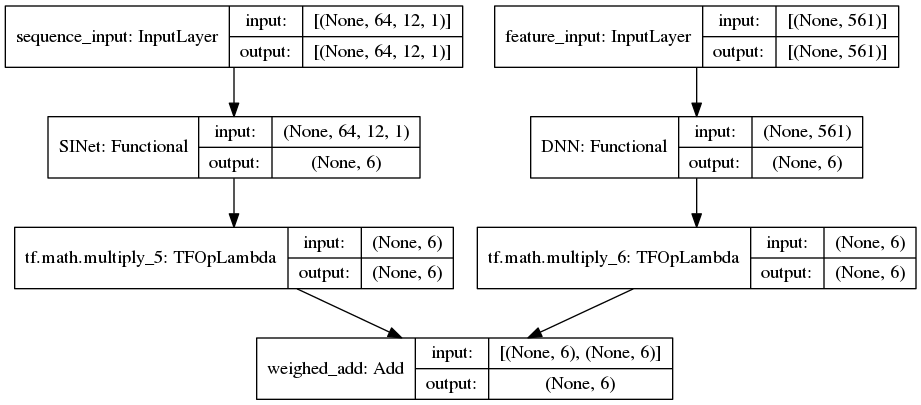

In [8]:
combined_model.summary()
tf.keras.utils.plot_model(combined_model,show_shapes=True)

In [9]:
# evaluate accuracy
sinet_model.evaluate(x_test,y_test)
fcn_model.evaluate(x_test_f,y_test_f)
combined_model.evaluate([x_test,x_test_f],y_test)

93/93 [==============================] - 1s 4ms/step - loss: 0.0000e+00 - acc: 0.9820


[0.0, 0.9820156097412109]